# Feature Importance Analysis - Comprehensive Comparison

**Objective:** Analyze feature importance using multiple methods and compare across models and regimes.

**Inputs:**

- Features with regimes from notebook 30 (`AAPL_features_with_regimes.parquet`)
- Trained models from notebooks 40, 45, 50, 55
- **Time period:** December 9-13, 2024 (5 trading days)

**Methods:**

- **Built-in importances:** Gini (Decision Tree, Random Forest), Gain (Gradient Boosting)
- **Permutation importance:** Model-agnostic, measures accuracy drop when feature is shuffled
- **SHAP values:** Game-theoretic feature attribution with directionality

**Analyses:**

- Cross-model comparison: which features matter most for each model type?
- Regime-conditional importance: do different features dominate in different regimes?
- Feature interactions: which feature pairs have synergistic effects?
- Importance stability: how consistent are importance rankings?

**Outputs:**

- Feature importance rankings by method and model
- SHAP summary plots (global importance + directionality)
- SHAP dependence plots (feature interactions)
- SHAP waterfall plots (individual prediction explanations)
- Regime-conditional importance comparison
- Feature interaction matrices

**Key Question:** Which features truly drive predictions, and does this differ across models and market regimes?


## 1. Setup and Imports


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import json
import warnings
from tqdm import tqdm

warnings.filterwarnings("ignore")

# Sklearn imports
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# SHAP imports
import shap

# Visualization
plt.style.use("seaborn-v0_8-paper")
plt.rcParams.update(
    {
        "font.family": "serif",
        "font.weight": "bold",
        "axes.labelweight": "bold",
        "axes.titleweight": "bold",
        "axes.linewidth": 1.2,
        "axes.spines.top": False,
        "axes.spines.right": False,
    }
)

# Import project config
import sys

sys.path.append("..")
from src.config import PROCESSED_DATA_DIR, MODELS_DIR, FIGURES_DIR, TABLES_DIR

# Create output directories
fi_dir = FIGURES_DIR / "feature_importance"
fi_dir.mkdir(parents=True, exist_ok=True)

# Set random seed
np.random.seed(42)

print("✓ Setup complete")
print(f"  Data directory: {PROCESSED_DATA_DIR}")
print(f"  Models directory: {MODELS_DIR}")
print(f"  Figures directory: {fi_dir}")

✓ Setup complete
  Data directory: /Users/rylanspence/Desktop/Git/HF/HFT-Equity-Prediction-Pipeline/notebooks/../data/processed
  Models directory: /Users/rylanspence/Desktop/Git/HF/HFT-Equity-Prediction-Pipeline/notebooks/../models
  Figures directory: /Users/rylanspence/Desktop/Git/HF/HFT-Equity-Prediction-Pipeline/notebooks/../reports/figures/feature_importance


In [2]:
# Configuration
TICKER = "AAPL"
START_DATE = "2024-12-09"
END_DATE = "2024-12-13"
DATE_RANGE = f"{START_DATE}_to_{END_DATE}"

print(f"Configuration:")
print(f"  Ticker: {TICKER}")
print(f"  Date range: {START_DATE} to {END_DATE}")
print(f"  Trading days: 5")

Configuration:
  Ticker: AAPL
  Date range: 2024-12-09 to 2024-12-13
  Trading days: 5


## 2. Load Data and Trained Models


In [3]:
# Load features with regimes
print("Loading features with regimes...")
features_with_regimes = pd.read_parquet(
    PROCESSED_DATA_DIR / "AAPL_features_with_regimes.parquet"
).reset_index(drop=True)

print(f"✓ Features with regimes: {features_with_regimes.shape}")

# Load trained models
print("\nLoading trained models...")

with open(MODELS_DIR / "decision_tree_tuned.pkl", "rb") as f:
    dt_model = pickle.load(f)
print("  ✓ Decision Tree")

with open(MODELS_DIR / "random_forest_tuned.pkl", "rb") as f:
    rf_model = pickle.load(f)
print("  ✓ Random Forest")

with open(MODELS_DIR / "gradient_boosting_tuned.pkl", "rb") as f:
    gb_model = pickle.load(f)
print("  ✓ Gradient Boosting")

# Load regime-specific models (if available)
try:
    with open(MODELS_DIR / "regime_models_rf.pkl", "rb") as f:
        regime_models_rf = pickle.load(f)
    print("  ✓ Regime-conditional Random Forest models")
    has_regime_models = True
except FileNotFoundError:
    print("  ⚠ Regime-conditional models not found (skipping regime analysis)")
    has_regime_models = False
    regime_models_rf = {}

print("\n✓ All models loaded")

Loading features with regimes...
✓ Features with regimes: (1365, 94)

Loading trained models...
  ✓ Decision Tree
  ✓ Random Forest
  ✓ Gradient Boosting
  ✓ Regime-conditional Random Forest models

✓ All models loaded


## 3. Prepare Data (Same as Model Training)


In [4]:
# Find price column
price_candidates = ["agg_mid_price", "agg_close", "mid_price", "close"]
price_col = next(
    (col for col in price_candidates if col in features_with_regimes.columns), None
)

if price_col is None:
    raise ValueError(f"No price column found")

print(f"Using price column: {price_col}")

# Create target
features_with_regimes["price_next"] = features_with_regimes[price_col].shift(-1)
features_with_regimes["target"] = (
    features_with_regimes["price_next"] > features_with_regimes[price_col]
).astype(int)
features_with_regimes = features_with_regimes[:-1].copy()

# Columns to exclude from features
exclude_cols = [
    "timestamp",
    "target",
    "price_next",
    "regime_hmm",
    "regime_hawkes",
    "regime_hawkes_binary",
    "hmm_state",
    "time_hour",
    "time_minute",
    "time_minutes_since_open",
    "time_session",
    "hour",
    "minute",
    "time_of_day",
]

# Get feature columns
feature_cols = [col for col in features_with_regimes.columns if col not in exclude_cols]

# Select only numeric features
X = features_with_regimes[feature_cols].select_dtypes(include=[np.number])
feature_cols = X.columns.tolist()

# Get target and regimes
y = features_with_regimes["target"].values
regimes = features_with_regimes["regime_hmm"].values

# Handle missing and infinite values
X = X.fillna(method="ffill").fillna(method="bfill").fillna(0)
X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

print(f"\n✓ Feature matrix: {X.shape}")
print(f"✓ Target vector: {y.shape}")
print(f"✓ Features: {len(feature_cols)}")

Using price column: agg_mid_price

✓ Feature matrix: (1364, 81)
✓ Target vector: (1364,)
✓ Features: 81


In [5]:
# Train-test split (same as model training)
split_idx = int(len(X) * 0.8)

X_train = X.iloc[:split_idx]
X_test = X.iloc[split_idx:]
y_train = y[:split_idx]
y_test = y[split_idx:]
regimes_train = regimes[:split_idx]
regimes_test = regimes[split_idx:]

print(f"Train set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")

Train set: 1,091 samples
Test set: 273 samples


## 4. Built-in Feature Importances

Extract built-in importances from tree-based models:

- **Decision Tree, Random Forest:** Gini importance (impurity reduction)
- **Gradient Boosting:** Gain-based importance (loss reduction)


In [6]:
# Extract built-in importances
print("Extracting built-in feature importances...\n")

# Decision Tree
dt_importance = pd.DataFrame(
    {"feature": feature_cols, "importance": dt_model.feature_importances_}
).sort_values("importance", ascending=False)

print("Decision Tree - Top 10 Features:")
print(dt_importance.head(10).to_string(index=False))

# Random Forest
rf_importance = pd.DataFrame(
    {"feature": feature_cols, "importance": rf_model.feature_importances_}
).sort_values("importance", ascending=False)

print("\nRandom Forest - Top 10 Features:")
print(rf_importance.head(10).to_string(index=False))

# Gradient Boosting
gb_importance = pd.DataFrame(
    {"feature": feature_cols, "importance": gb_model.feature_importances_}
).sort_values("importance", ascending=False)

print("\nGradient Boosting - Top 10 Features:")
print(gb_importance.head(10).to_string(index=False))

print("\n✓ Built-in importances extracted")

Extracting built-in feature importances...

Decision Tree - Top 10 Features:
                       feature  importance
impact_permanent_impact_5_mean    0.560196
            agg_vwap_deviation    0.188334
               regime_duration    0.070719
             trade_sell_volume    0.035781
      agg_volume_concentration    0.034566
               adv_return_skew    0.031105
          adv_variance_ratio_5    0.029574
     cluster_inter_arrival_std    0.027810
              trade_size_ma_10    0.021915
            adv_rv_scale_10min    0.000000

Random Forest - Top 10 Features:
                       feature  importance
impact_permanent_impact_5_mean    0.299186
            agg_vwap_deviation    0.088524
         agg_intrabar_momentum    0.071932
        trade_volume_imbalance    0.023913
  impact_impact_per_share_mean    0.017116
                    agg_trades    0.014698
     cluster_inter_arrival_std    0.014321
       impact_temp_impact_mean    0.014117
 trade_size_weighted_directio

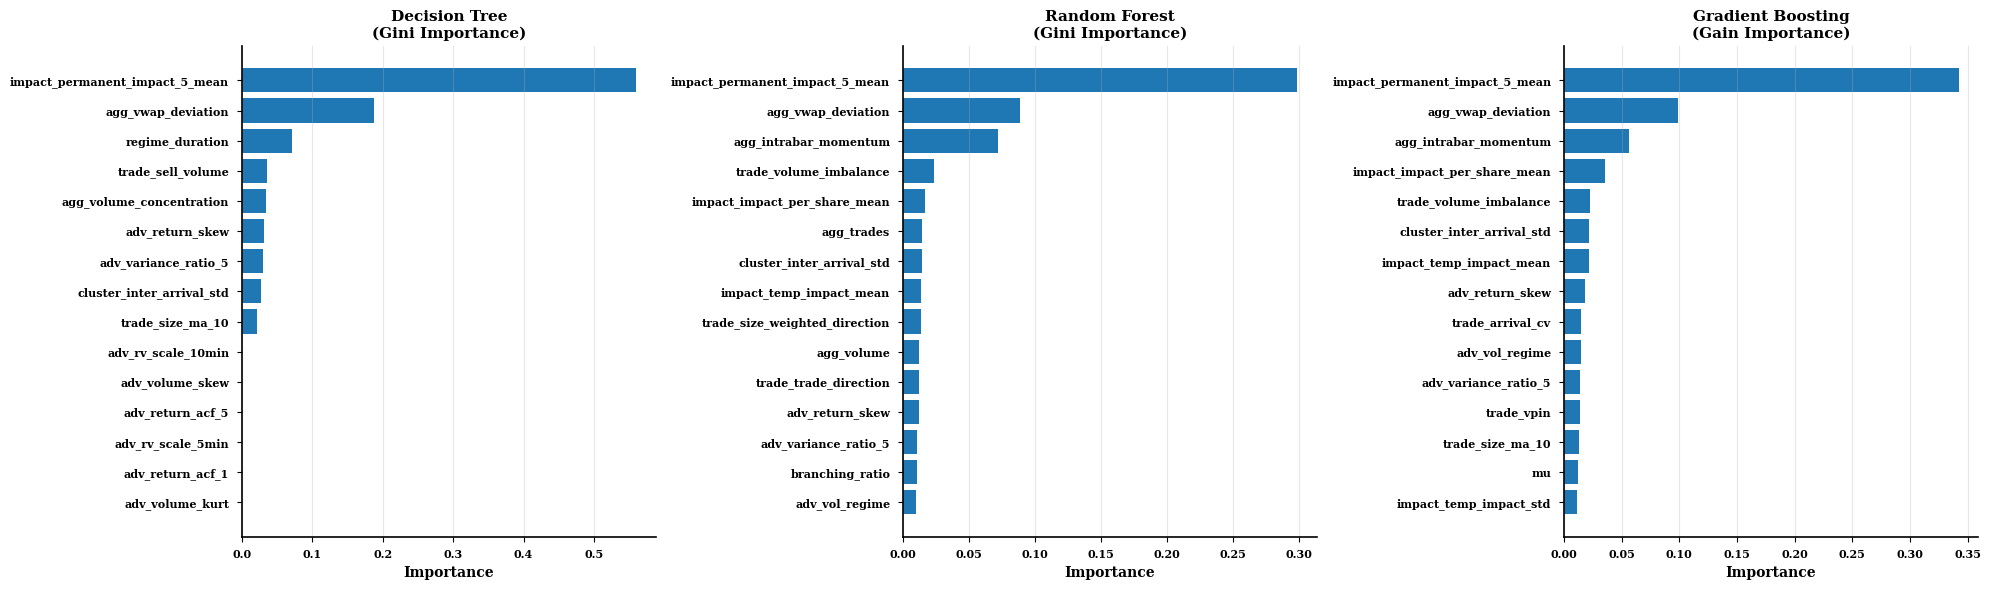


✓ Saved to /Users/rylanspence/Desktop/Git/HF/HFT-Equity-Prediction-Pipeline/notebooks/../reports/figures/feature_importance/builtin_importance_comparison.png


In [7]:
# Visualize built-in importances
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

models = [
    (dt_importance, "Decision Tree\n(Gini Importance)"),
    (rf_importance, "Random Forest\n(Gini Importance)"),
    (gb_importance, "Gradient Boosting\n(Gain Importance)"),
]

for idx, (importance_df, title) in enumerate(models):
    top_features = importance_df.head(15)
    axes[idx].barh(range(len(top_features)), top_features["importance"].values)
    axes[idx].set_yticks(range(len(top_features)))
    axes[idx].set_yticklabels(top_features["feature"].values, fontsize=8)
    axes[idx].set_xlabel("Importance", fontsize=10)
    axes[idx].set_title(title, fontsize=11, fontweight="bold")
    axes[idx].grid(axis="x", alpha=0.3)
    axes[idx].invert_yaxis()

plt.tight_layout()
plt.savefig(fi_dir / "builtin_importance_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"\n✓ Saved to {fi_dir / 'builtin_importance_comparison.png'}")

## 5. Permutation Importance

**Permutation importance** measures the drop in model performance when a feature's values are randomly shuffled.

- More reliable than built-in importances (not biased by tree structure)
- Model-agnostic method
- Captures true predictive power of each feature


In [8]:
# Compute permutation importance for all models
print("Computing permutation importance...\n")

# Decision Tree
print("  Decision Tree...", end=" ")
dt_perm = permutation_importance(
    dt_model, X_test, y_test, n_repeats=10, random_state=42, scoring="f1", n_jobs=-1
)
dt_perm_importance = pd.DataFrame(
    {
        "feature": feature_cols,
        "importance_mean": dt_perm.importances_mean,
        "importance_std": dt_perm.importances_std,
    }
).sort_values("importance_mean", ascending=False)
print("done")

# Random Forest
print("  Random Forest...", end=" ")
rf_perm = permutation_importance(
    rf_model, X_test, y_test, n_repeats=10, random_state=42, scoring="f1", n_jobs=-1
)
rf_perm_importance = pd.DataFrame(
    {
        "feature": feature_cols,
        "importance_mean": rf_perm.importances_mean,
        "importance_std": rf_perm.importances_std,
    }
).sort_values("importance_mean", ascending=False)
print("done")

# Gradient Boosting
print("  Gradient Boosting...", end=" ")
gb_perm = permutation_importance(
    gb_model, X_test, y_test, n_repeats=10, random_state=42, scoring="f1", n_jobs=-1
)
gb_perm_importance = pd.DataFrame(
    {
        "feature": feature_cols,
        "importance_mean": gb_perm.importances_mean,
        "importance_std": gb_perm.importances_std,
    }
).sort_values("importance_mean", ascending=False)
print("done")

print("\n✓ Permutation importance computed for all models")

Computing permutation importance...

  Decision Tree... done
  Random Forest... done
  Gradient Boosting... done

✓ Permutation importance computed for all models


In [9]:
# Display top permutation importances
print("=" * 80)
print("PERMUTATION IMPORTANCE - TOP 15 FEATURES")
print("=" * 80)

print("\nDecision Tree:")
print(dt_perm_importance.head(15).to_string(index=False))

print("\nRandom Forest:")
print(rf_perm_importance.head(15).to_string(index=False))

print("\nGradient Boosting:")
print(gb_perm_importance.head(15).to_string(index=False))

PERMUTATION IMPORTANCE - TOP 15 FEATURES

Decision Tree:
                       feature  importance_mean  importance_std
impact_permanent_impact_5_mean         0.099501        0.032059
            agg_vwap_deviation         0.030133        0.008540
      agg_volume_concentration         0.018722        0.006289
                    agg_volume         0.000000        0.000000
              adv_return_acf_5         0.000000        0.000000
              adv_return_acf_1         0.000000        0.000000
               adv_volume_kurt         0.000000        0.000000
               adv_volume_skew         0.000000        0.000000
               adv_return_kurt         0.000000        0.000000
               adv_return_skew         0.000000        0.000000
                adv_vol_regime         0.000000        0.000000
              adv_volume_acf_1         0.000000        0.000000
             adv_vol_ewma_slow         0.000000        0.000000
             adv_vol_ewma_fast         0.000000

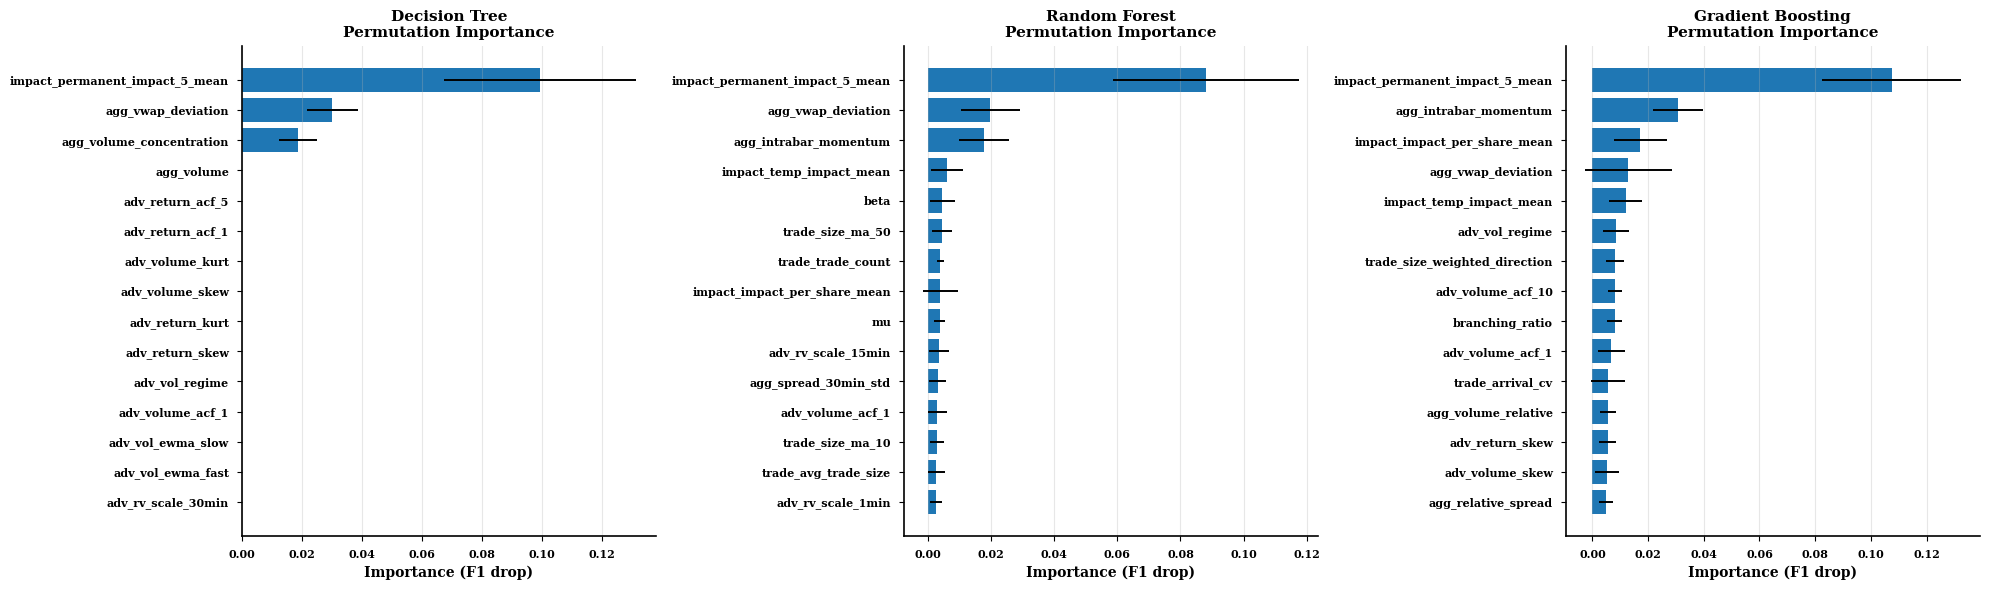


✓ Saved to /Users/rylanspence/Desktop/Git/HF/HFT-Equity-Prediction-Pipeline/notebooks/../reports/figures/feature_importance/permutation_importance_comparison.png


In [10]:
# Visualize permutation importance with error bars
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

perm_models = [
    (dt_perm_importance, "Decision Tree"),
    (rf_perm_importance, "Random Forest"),
    (gb_perm_importance, "Gradient Boosting"),
]

for idx, (perm_df, title) in enumerate(perm_models):
    top_features = perm_df.head(15)
    y_pos = range(len(top_features))

    axes[idx].barh(
        y_pos,
        top_features["importance_mean"].values,
        xerr=top_features["importance_std"].values,
    )
    axes[idx].set_yticks(y_pos)
    axes[idx].set_yticklabels(top_features["feature"].values, fontsize=8)
    axes[idx].set_xlabel("Importance (F1 drop)", fontsize=10)
    axes[idx].set_title(
        f"{title}\nPermutation Importance", fontsize=11, fontweight="bold"
    )
    axes[idx].grid(axis="x", alpha=0.3)
    axes[idx].invert_yaxis()

plt.tight_layout()
plt.savefig(
    fi_dir / "permutation_importance_comparison.png", dpi=300, bbox_inches="tight"
)
plt.show()

print(f"\n✓ Saved to {fi_dir / 'permutation_importance_comparison.png'}")

## 6. SHAP Analysis - Random Forest

**SHAP (SHapley Additive exPlanations)** provides game-theoretic feature attributions:

- Global importance: mean absolute SHAP values
- Directionality: positive (increases "up" probability) vs. negative SHAP
- Local explanations: individual prediction breakdowns

We'll focus on Random Forest for SHAP analysis (good balance of accuracy and interpretability).


In [11]:
# Create SHAP explainer for Random Forest
print("Creating SHAP explainer for Random Forest...")
print("This may take a few minutes...\n")

# Use TreeExplainer for tree-based models (much faster than KernelExplainer)
explainer_rf = shap.TreeExplainer(rf_model)

# Compute SHAP values on test set (use subset for speed)
# For large datasets, sample 100-500 examples
n_shap_samples = min(500, len(X_test))
X_test_shap = X_test.iloc[:n_shap_samples]
y_test_shap = y_test[:n_shap_samples]

print(f"Computing SHAP values for {n_shap_samples} test samples...")
shap_values_rf = explainer_rf.shap_values(X_test_shap)

# For binary classification, shap_values is a list [class_0, class_1]
# We want class 1 ("up") SHAP values
if isinstance(shap_values_rf, list):
    shap_values_rf_class1 = shap_values_rf[1]
else:
    shap_values_rf_class1 = shap_values_rf

# Debug: check shape
print(f"\nDEBUG - SHAP values shape: {shap_values_rf_class1.shape}")
print(f"Expected shape: ({n_shap_samples}, {len(feature_cols)})")

# Ensure 2D shape (samples, features)
if len(shap_values_rf_class1.shape) == 3:
    # If 3D (samples, features, classes), take last dimension
    shap_values_rf_class1 = shap_values_rf_class1[:, :, 1]
    print(f"Converted 3D to 2D, new shape: {shap_values_rf_class1.shape}")

print(f"\n✓ SHAP values computed: {shap_values_rf_class1.shape}")

Creating SHAP explainer for Random Forest...
This may take a few minutes...

Computing SHAP values for 273 test samples...

DEBUG - SHAP values shape: (273, 81, 2)
Expected shape: (273, 81)
Converted 3D to 2D, new shape: (273, 81)

✓ SHAP values computed: (273, 81)


In [12]:
# Compute global feature importance from SHAP values
shap_importance = pd.DataFrame(
    {
        "feature": feature_cols,
        "importance": np.abs(shap_values_rf_class1).mean(axis=0),
    }
).sort_values("importance", ascending=False)

print("=" * 80)
print("SHAP GLOBAL IMPORTANCE (Random Forest) - TOP 20")
print("=" * 80)
print(shap_importance.head(20).to_string(index=False))

print(
    f"\nTop 10 features account for {100*shap_importance.head(10)['importance'].sum() / shap_importance['importance'].sum():.1f}% of total SHAP importance"
)

SHAP GLOBAL IMPORTANCE (Random Forest) - TOP 20
                       feature  importance
impact_permanent_impact_5_mean    0.114863
         agg_intrabar_momentum    0.037171
            agg_vwap_deviation    0.030473
        trade_volume_imbalance    0.012941
     cluster_inter_arrival_std    0.007110
  impact_impact_per_share_mean    0.006672
       impact_temp_impact_mean    0.006366
               branching_ratio    0.005063
         trade_trade_direction    0.004909
                adv_vol_regime    0.004043
                    agg_trades    0.004000
                          beta    0.003895
               adv_return_skew    0.003621
          adv_variance_ratio_5    0.003533
                    trade_vpin    0.003436
 trade_size_weighted_direction    0.003357
                    agg_volume    0.003253
          agg_spread_30min_std    0.003231
               adv_volume_kurt    0.003172
               adv_volume_skew    0.003152

Top 10 features account for 67.6% of total SHAP 

## 7. SHAP Summary Plot

**SHAP summary plot (beeswarm)** shows:

- Feature importance (vertical axis ordering)
- Effect direction (horizontal axis: positive = pushes prediction "up")
- Feature value (color: red = high value, blue = low value)


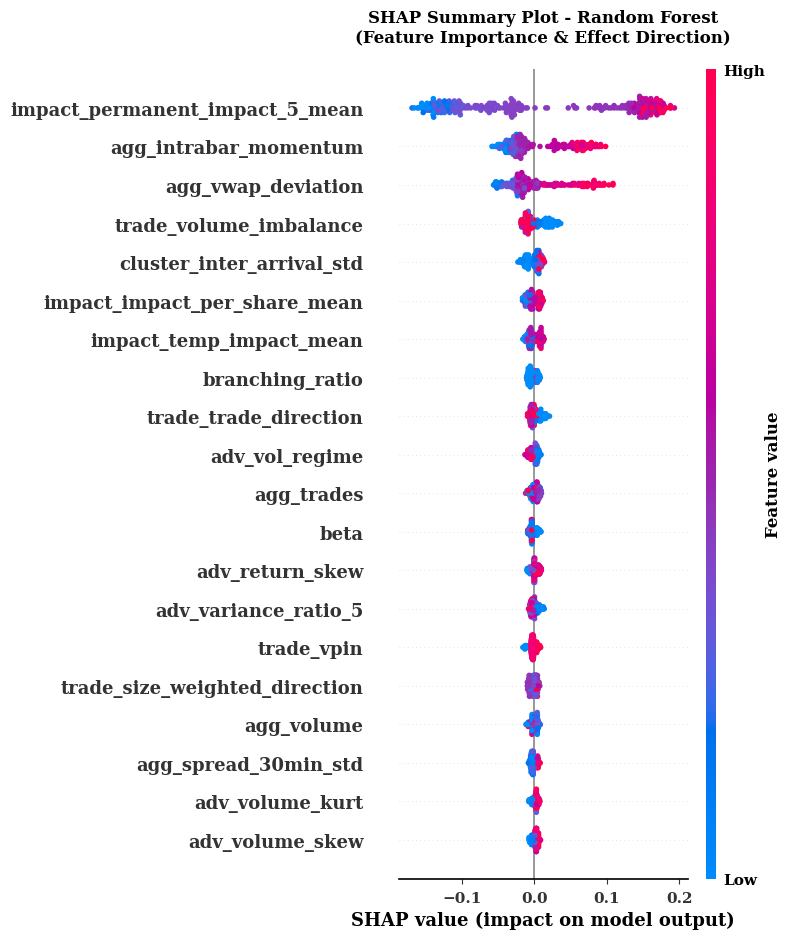


✓ Saved to /Users/rylanspence/Desktop/Git/HF/HFT-Equity-Prediction-Pipeline/notebooks/../reports/figures/feature_importance/shap_summary_plot.png


In [13]:
# SHAP summary plot
plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_values_rf_class1,
    X_test_shap,
    feature_names=feature_cols,
    show=False,
    max_display=20,
)
plt.title(
    "SHAP Summary Plot - Random Forest\n(Feature Importance & Effect Direction)",
    fontsize=12,
    fontweight="bold",
    pad=20,
)
plt.tight_layout()
plt.savefig(fi_dir / "shap_summary_plot.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"\n✓ Saved to {fi_dir / 'shap_summary_plot.png'}")

## 8. SHAP Dependence Plots

**SHAP dependence plots** show how a feature's value affects predictions:

- X-axis: feature value
- Y-axis: SHAP value (impact on prediction)
- Color: interaction feature (automatically selected)


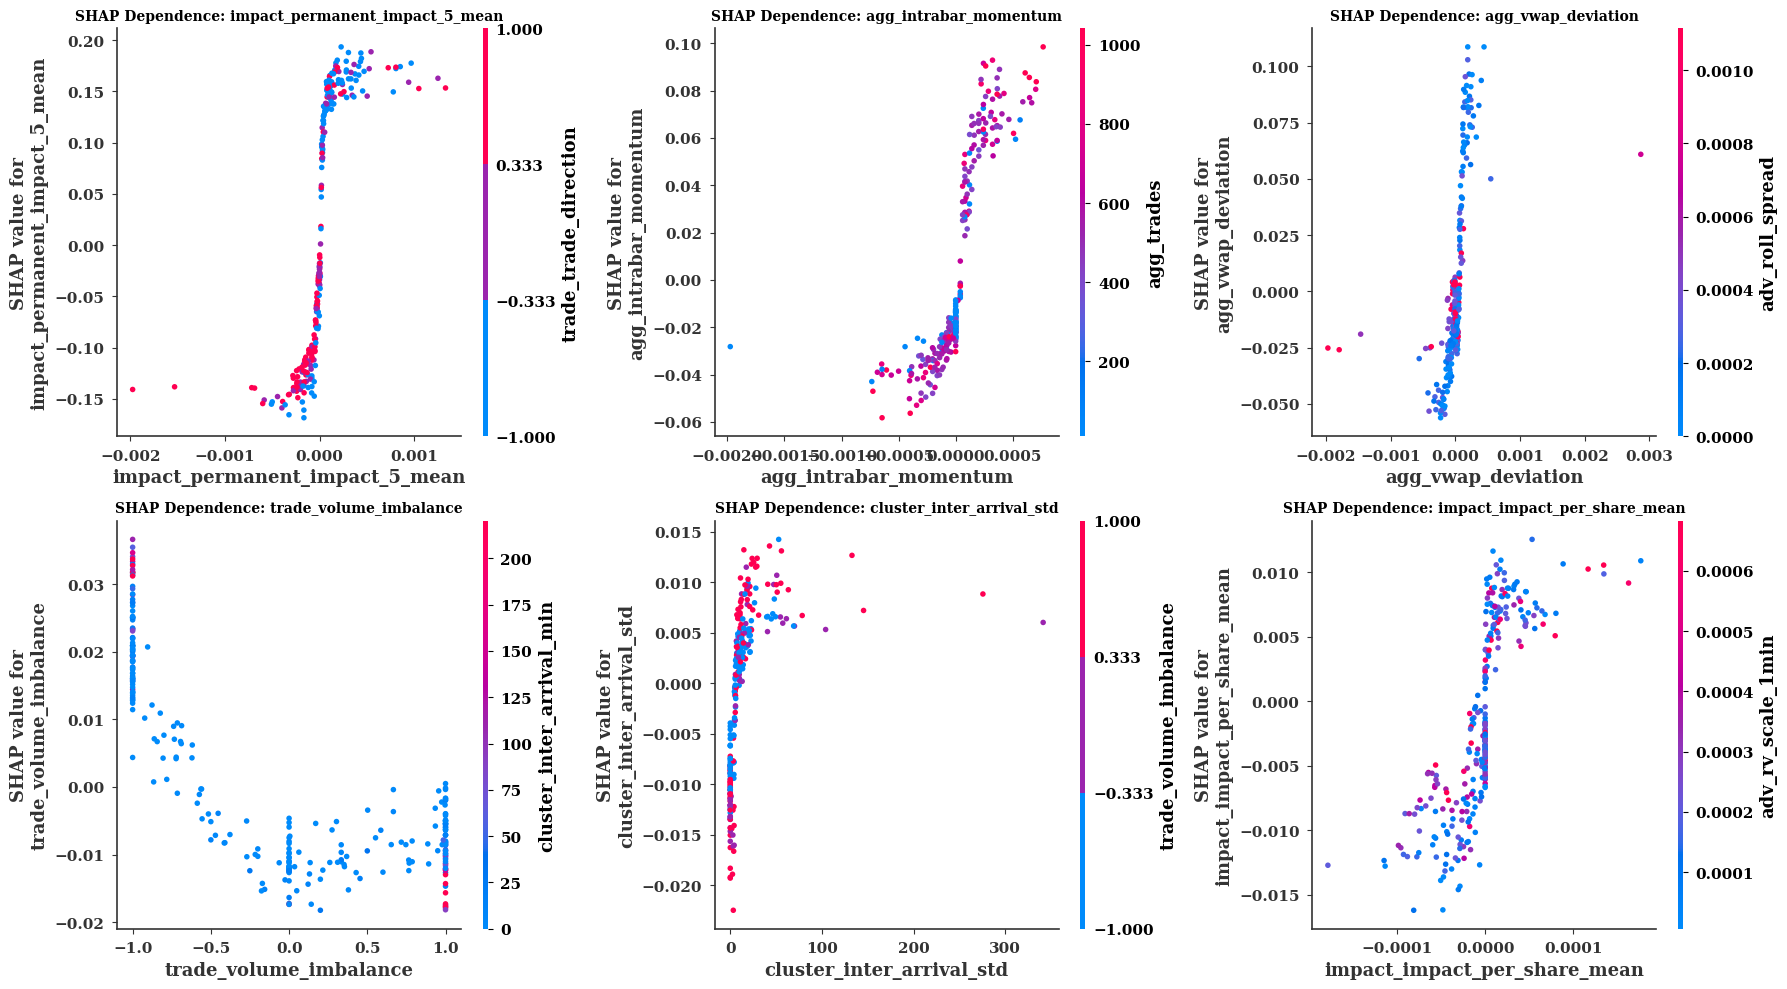


✓ Saved to /Users/rylanspence/Desktop/Git/HF/HFT-Equity-Prediction-Pipeline/notebooks/../reports/figures/feature_importance/shap_dependence_plots.png


In [14]:
# Plot dependence for top 6 features
top_6_features = shap_importance.head(6)["feature"].values

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, feature in enumerate(top_6_features):
    plt.sca(axes[idx])
    shap.dependence_plot(
        feature,
        shap_values_rf_class1,
        X_test_shap,
        feature_names=feature_cols,
        show=False,
        ax=axes[idx],
    )
    axes[idx].set_title(f"SHAP Dependence: {feature}", fontsize=10, fontweight="bold")

plt.tight_layout()
plt.savefig(fi_dir / "shap_dependence_plots.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"\n✓ Saved to {fi_dir / 'shap_dependence_plots.png'}")

## 9. SHAP Waterfall Plots (Individual Predictions)

**SHAP waterfall plots** explain individual predictions by showing each feature's contribution.


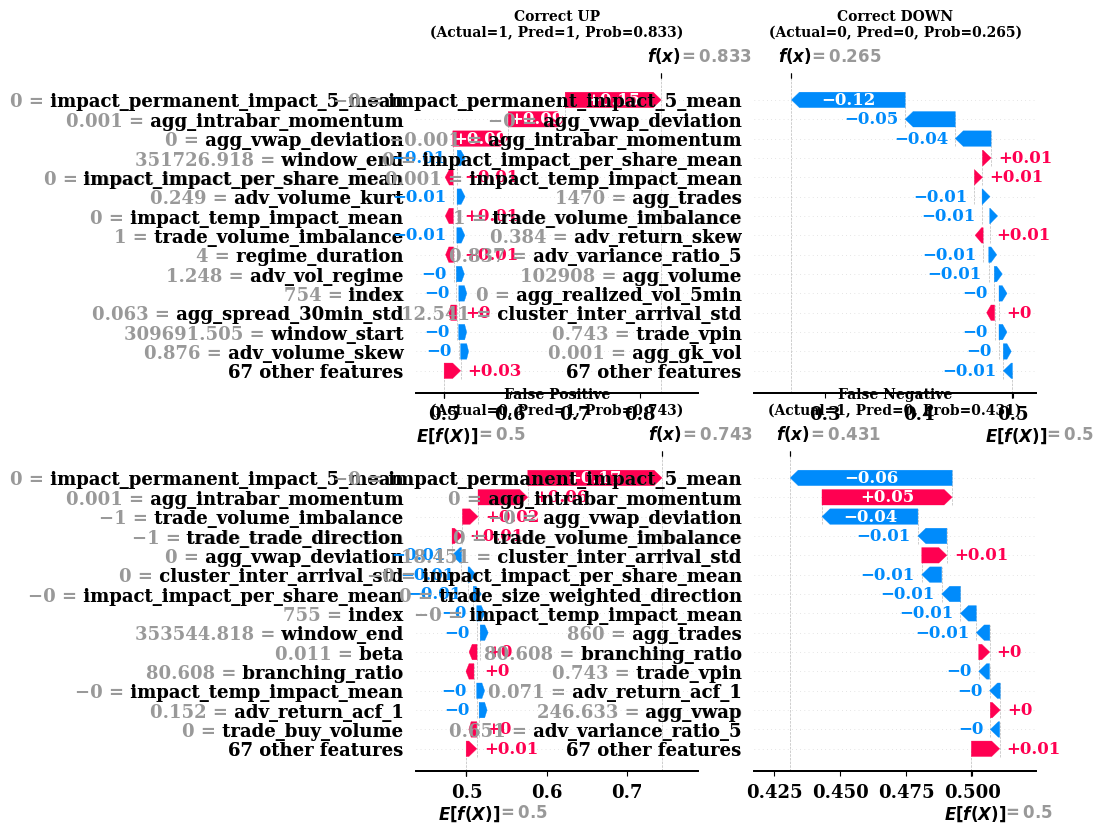


✓ Saved to /Users/rylanspence/Desktop/Git/HF/HFT-Equity-Prediction-Pipeline/notebooks/../reports/figures/feature_importance/shap_waterfall_examples.png


In [15]:
# Select 4 interesting examples: 2 correct, 2 incorrect
y_pred_shap = rf_model.predict(X_test_shap)
y_proba_shap = rf_model.predict_proba(X_test_shap)[:, 1]

# Find examples
correct_up = np.where((y_test_shap == 1) & (y_pred_shap == 1))[0]
correct_down = np.where((y_test_shap == 0) & (y_pred_shap == 0))[0]
incorrect_fp = np.where((y_test_shap == 0) & (y_pred_shap == 1))[0]  # False positive
incorrect_fn = np.where((y_test_shap == 1) & (y_pred_shap == 0))[0]  # False negative

# Select one from each category (if available)
examples = []
if len(correct_up) > 0:
    examples.append((correct_up[0], "Correct UP"))
if len(correct_down) > 0:
    examples.append((correct_down[0], "Correct DOWN"))
if len(incorrect_fp) > 0:
    examples.append((incorrect_fp[0], "False Positive"))
if len(incorrect_fn) > 0:
    examples.append((incorrect_fn[0], "False Negative"))

# Plot waterfall for each example
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, (example_idx, label) in enumerate(examples[:4]):
    plt.sca(axes[idx])

    # Create explanation object for waterfall plot
    shap_explanation = shap.Explanation(
        values=shap_values_rf_class1[example_idx],
        base_values=explainer_rf.expected_value[1],
        data=X_test_shap.iloc[example_idx].values,
        feature_names=feature_cols,
    )

    shap.waterfall_plot(shap_explanation, max_display=15, show=False)
    axes[idx].set_title(
        f"{label}\n(Actual={y_test_shap[example_idx]}, Pred={y_pred_shap[example_idx]}, Prob={y_proba_shap[example_idx]:.3f})",
        fontsize=10,
        fontweight="bold",
    )

plt.tight_layout()
plt.savefig(fi_dir / "shap_waterfall_examples.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"\n✓ Saved to {fi_dir / 'shap_waterfall_examples.png'}")

## 10. Cross-Method Comparison

Compare feature rankings across all three importance methods:

- Built-in (Gini/Gain)
- Permutation
- SHAP


In [16]:
# Compare rankings for Random Forest
# Normalize importances to 0-1 range for comparison
rf_builtin_norm = rf_importance.copy()
rf_builtin_norm["importance_norm"] = (
    rf_builtin_norm["importance"] / rf_builtin_norm["importance"].sum()
)

rf_perm_norm = rf_perm_importance.copy()
rf_perm_norm["importance_norm"] = (
    rf_perm_norm["importance_mean"] / rf_perm_norm["importance_mean"].sum()
)

shap_norm = shap_importance.copy()
shap_norm["importance_norm"] = shap_norm["importance"] / shap_norm["importance"].sum()

# Merge all three methods
comparison = (
    rf_builtin_norm[["feature", "importance_norm"]]
    .rename(columns={"importance_norm": "builtin"})
    .merge(
        rf_perm_norm[["feature", "importance_norm"]].rename(
            columns={"importance_norm": "permutation"}
        ),
        on="feature",
    )
    .merge(
        shap_norm[["feature", "importance_norm"]].rename(
            columns={"importance_norm": "shap"}
        ),
        on="feature",
    )
)

# Compute average rank
comparison["avg_importance"] = comparison[["builtin", "permutation", "shap"]].mean(
    axis=1
)
comparison = comparison.sort_values("avg_importance", ascending=False)

print("=" * 80)
print("CROSS-METHOD COMPARISON (Random Forest) - TOP 20")
print("=" * 80)
print(comparison.head(20).to_string(index=False))

CROSS-METHOD COMPARISON (Random Forest) - TOP 20
                       feature  builtin  permutation     shap  avg_importance
impact_permanent_impact_5_mean 0.299186     0.437553 0.338282        0.358340
            agg_vwap_deviation 0.088524     0.098111 0.089745        0.092127
         agg_intrabar_momentum 0.071932     0.088078 0.109473        0.089827
       impact_temp_impact_mean 0.014117     0.029553 0.018749        0.020806
  impact_impact_per_share_mean 0.017116     0.019133 0.019650        0.018633
                          beta 0.008979     0.022680 0.011470        0.014376
        trade_volume_imbalance 0.023913    -0.022665 0.038113        0.013120
          agg_spread_30min_std 0.009436     0.014905 0.009515        0.011285
     cluster_inter_arrival_std 0.014321    -0.002083 0.020941        0.011059
              trade_size_ma_50 0.006982     0.022450 0.003439        0.010957
               branching_ratio 0.010465     0.007341 0.014911        0.010906
               

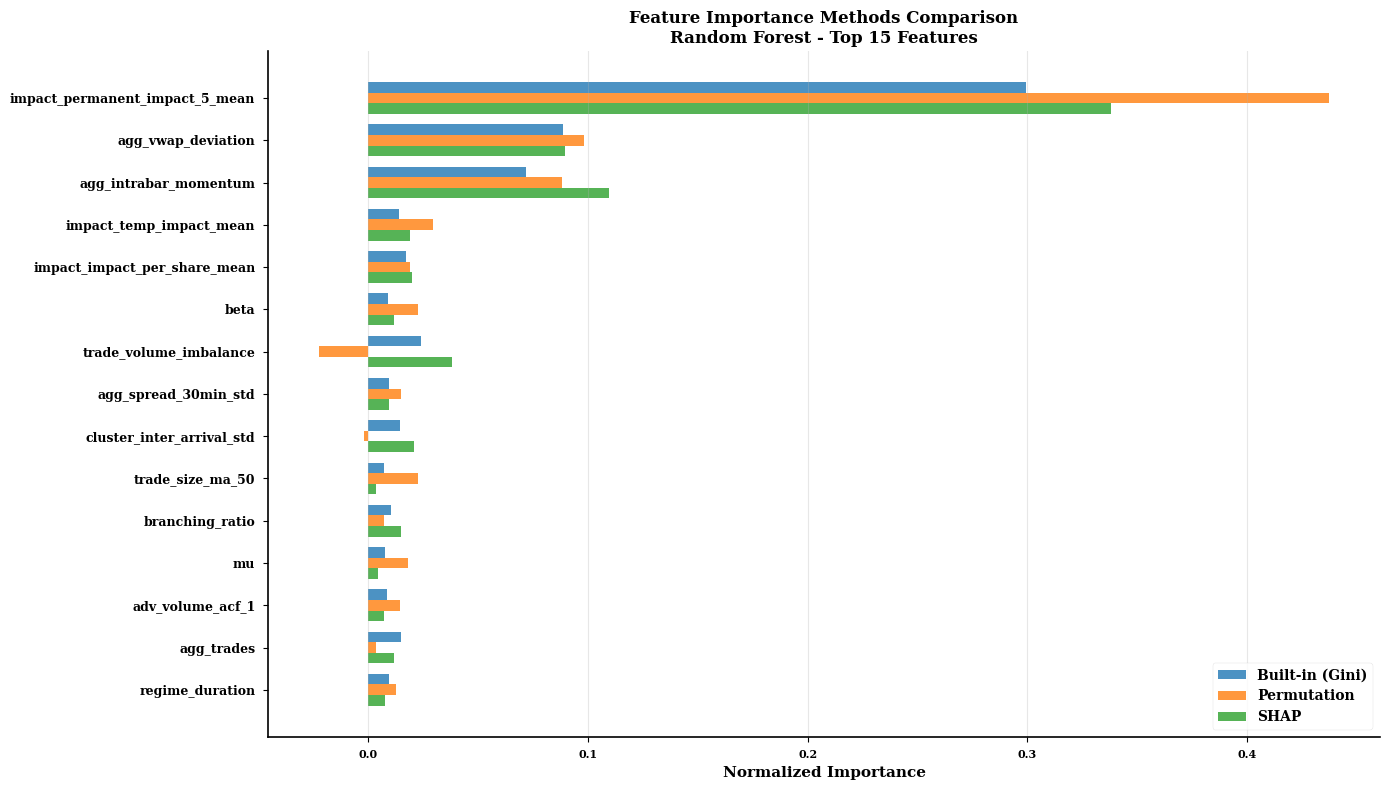


✓ Saved to /Users/rylanspence/Desktop/Git/HF/HFT-Equity-Prediction-Pipeline/notebooks/../reports/figures/feature_importance/cross_method_comparison.png


In [17]:
# Visualize cross-method comparison for top 15 features
top_15_comparison = comparison.head(15)

fig, ax = plt.subplots(figsize=(14, 8))

x = np.arange(len(top_15_comparison))
width = 0.25

ax.barh(
    x - width,
    top_15_comparison["builtin"],
    width,
    label="Built-in (Gini)",
    alpha=0.8,
)
ax.barh(x, top_15_comparison["permutation"], width, label="Permutation", alpha=0.8)
ax.barh(x + width, top_15_comparison["shap"], width, label="SHAP", alpha=0.8)

ax.set_yticks(x)
ax.set_yticklabels(top_15_comparison["feature"], fontsize=9)
ax.set_xlabel("Normalized Importance", fontsize=11)
ax.set_title(
    "Feature Importance Methods Comparison\nRandom Forest - Top 15 Features",
    fontsize=12,
    fontweight="bold",
)
ax.legend(fontsize=10)
ax.grid(axis="x", alpha=0.3)
ax.invert_yaxis()

plt.tight_layout()
plt.savefig(fi_dir / "cross_method_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"\n✓ Saved to {fi_dir / 'cross_method_comparison.png'}")

## 11. Regime-Conditional Feature Importance

Analyze whether different features dominate in different market regimes.


In [18]:
if has_regime_models and len(regime_models_rf) > 0:
    print("=" * 80)
    print("REGIME-CONDITIONAL FEATURE IMPORTANCE")
    print("=" * 80)

    regime_importances = {}

    for regime, model in regime_models_rf.items():
        importance_df = pd.DataFrame(
            {"feature": feature_cols, "importance": model.feature_importances_}
        ).sort_values("importance", ascending=False)
        regime_importances[regime] = importance_df

        print(f"\n{regime} Regime - Top 10 Features:")
        print(importance_df.head(10).to_string(index=False))

    print("\n✓ Regime-conditional importances computed")
else:
    print("⚠ Skipping regime-conditional analysis (no regime models available)")

REGIME-CONDITIONAL FEATURE IMPORTANCE

Trending Regime - Top 10 Features:
                       feature  importance
impact_permanent_impact_5_mean    0.162059
            agg_vwap_deviation    0.044779
         agg_intrabar_momentum    0.040302
       impact_temp_impact_mean    0.019487
        trade_volume_imbalance    0.019383
                    trade_vpin    0.019189
      agg_volume_concentration    0.018083
               adv_volume_kurt    0.016576
                    agg_volume    0.016354
             adv_vol_ewma_slow    0.015833

Calm Regime - Top 10 Features:
                       feature  importance
impact_permanent_impact_5_mean    0.129564
         agg_intrabar_momentum    0.093772
            agg_vwap_deviation    0.061013
          agg_spread_30min_std    0.024739
             adv_vol_ewma_slow    0.023689
            adv_rv_scale_15min    0.021820
                    agg_trades    0.017755
        trade_volume_imbalance    0.017451
            adv_rv_scale_30min    

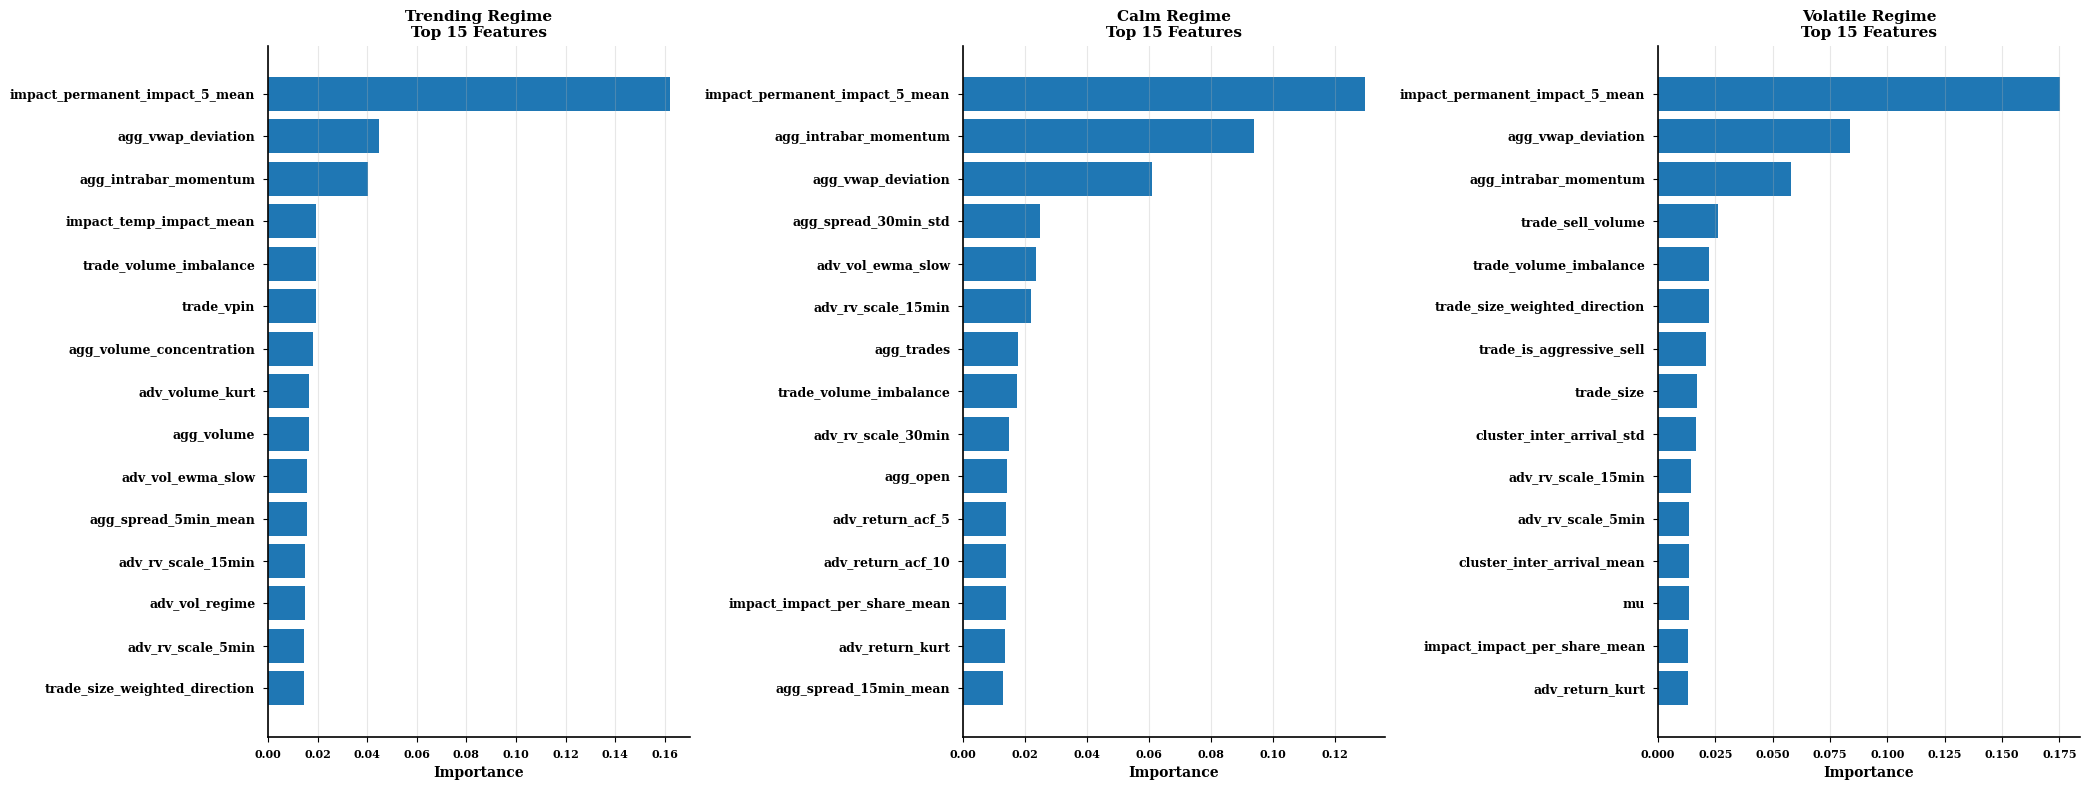


✓ Saved to /Users/rylanspence/Desktop/Git/HF/HFT-Equity-Prediction-Pipeline/notebooks/../reports/figures/feature_importance/regime_conditional_importance.png


In [19]:
if has_regime_models and len(regime_models_rf) > 0:
    # Visualize regime-conditional importance
    n_regimes = len(regime_importances)
    fig, axes = plt.subplots(1, n_regimes, figsize=(7 * n_regimes, 8))

    if n_regimes == 1:
        axes = [axes]

    for idx, (regime, importance_df) in enumerate(regime_importances.items()):
        top_features = importance_df.head(15)
        axes[idx].barh(range(len(top_features)), top_features["importance"].values)
        axes[idx].set_yticks(range(len(top_features)))
        axes[idx].set_yticklabels(top_features["feature"].values, fontsize=9)
        axes[idx].set_xlabel("Importance", fontsize=10)
        axes[idx].set_title(
            f"{regime} Regime\nTop 15 Features", fontsize=11, fontweight="bold"
        )
        axes[idx].grid(axis="x", alpha=0.3)
        axes[idx].invert_yaxis()

    plt.tight_layout()
    plt.savefig(
        fi_dir / "regime_conditional_importance.png", dpi=300, bbox_inches="tight"
    )
    plt.show()

    print(f"\n✓ Saved to {fi_dir / 'regime_conditional_importance.png'}")

## 12. Feature Interaction Analysis

Use SHAP interaction values to identify feature pairs with synergistic effects.


In [20]:
# Compute SHAP interaction values (expensive - use small sample)
print("Computing SHAP interaction values...")
print("This may take several minutes...\n")

n_interaction_samples = min(100, len(X_test))
X_test_interaction = X_test.iloc[:n_interaction_samples]

print(f"Computing for {n_interaction_samples} samples...")
shap_interaction_values = explainer_rf.shap_interaction_values(X_test_interaction)

# For binary classification, extract class 1 interactions
if isinstance(shap_interaction_values, list):
    shap_interaction_class1 = shap_interaction_values[1]
else:
    shap_interaction_class1 = shap_interaction_values

print(f"\n✓ SHAP interaction values computed: {shap_interaction_class1.shape}")

Computing SHAP interaction values...
This may take several minutes...

Computing for 100 samples...

✓ SHAP interaction values computed: (100, 81, 81, 2)


In [21]:
# Compute mean absolute interaction strength for each feature pair
n_features = len(feature_cols)
interaction_matrix = np.zeros((n_features, n_features))

for i in range(n_features):
    for j in range(n_features):
        # Mean absolute interaction between features i and j
        interaction_matrix[i, j] = np.abs(shap_interaction_class1[:, i, j]).mean()

# Create DataFrame
interaction_df = pd.DataFrame(
    interaction_matrix, index=feature_cols, columns=feature_cols
)

# Find top interactions (excluding diagonal)
top_interactions = []
for i in range(n_features):
    for j in range(i + 1, n_features):  # Only upper triangle
        top_interactions.append(
            {
                "feature_1": feature_cols[i],
                "feature_2": feature_cols[j],
                "interaction_strength": interaction_matrix[i, j],
            }
        )

top_interactions_df = pd.DataFrame(top_interactions).sort_values(
    "interaction_strength", ascending=False
)

print("=" * 80)
print("TOP 20 FEATURE INTERACTIONS")
print("=" * 80)
print(top_interactions_df.head(20).to_string(index=False))

TOP 20 FEATURE INTERACTIONS
                     feature_1                      feature_2  interaction_strength
         agg_intrabar_momentum impact_permanent_impact_5_mean              0.004542
            agg_vwap_deviation impact_permanent_impact_5_mean              0.004208
        trade_volume_imbalance impact_permanent_impact_5_mean              0.002758
               adv_return_skew impact_permanent_impact_5_mean              0.002092
         agg_intrabar_momentum         trade_volume_imbalance              0.001836
impact_permanent_impact_5_mean      cluster_inter_arrival_std              0.001739
         trade_trade_direction impact_permanent_impact_5_mean              0.001688
            agg_vwap_deviation          agg_intrabar_momentum              0.001554
 trade_size_weighted_direction impact_permanent_impact_5_mean              0.001533
            agg_vwap_deviation         trade_volume_imbalance              0.001527
impact_permanent_impact_5_mean                  

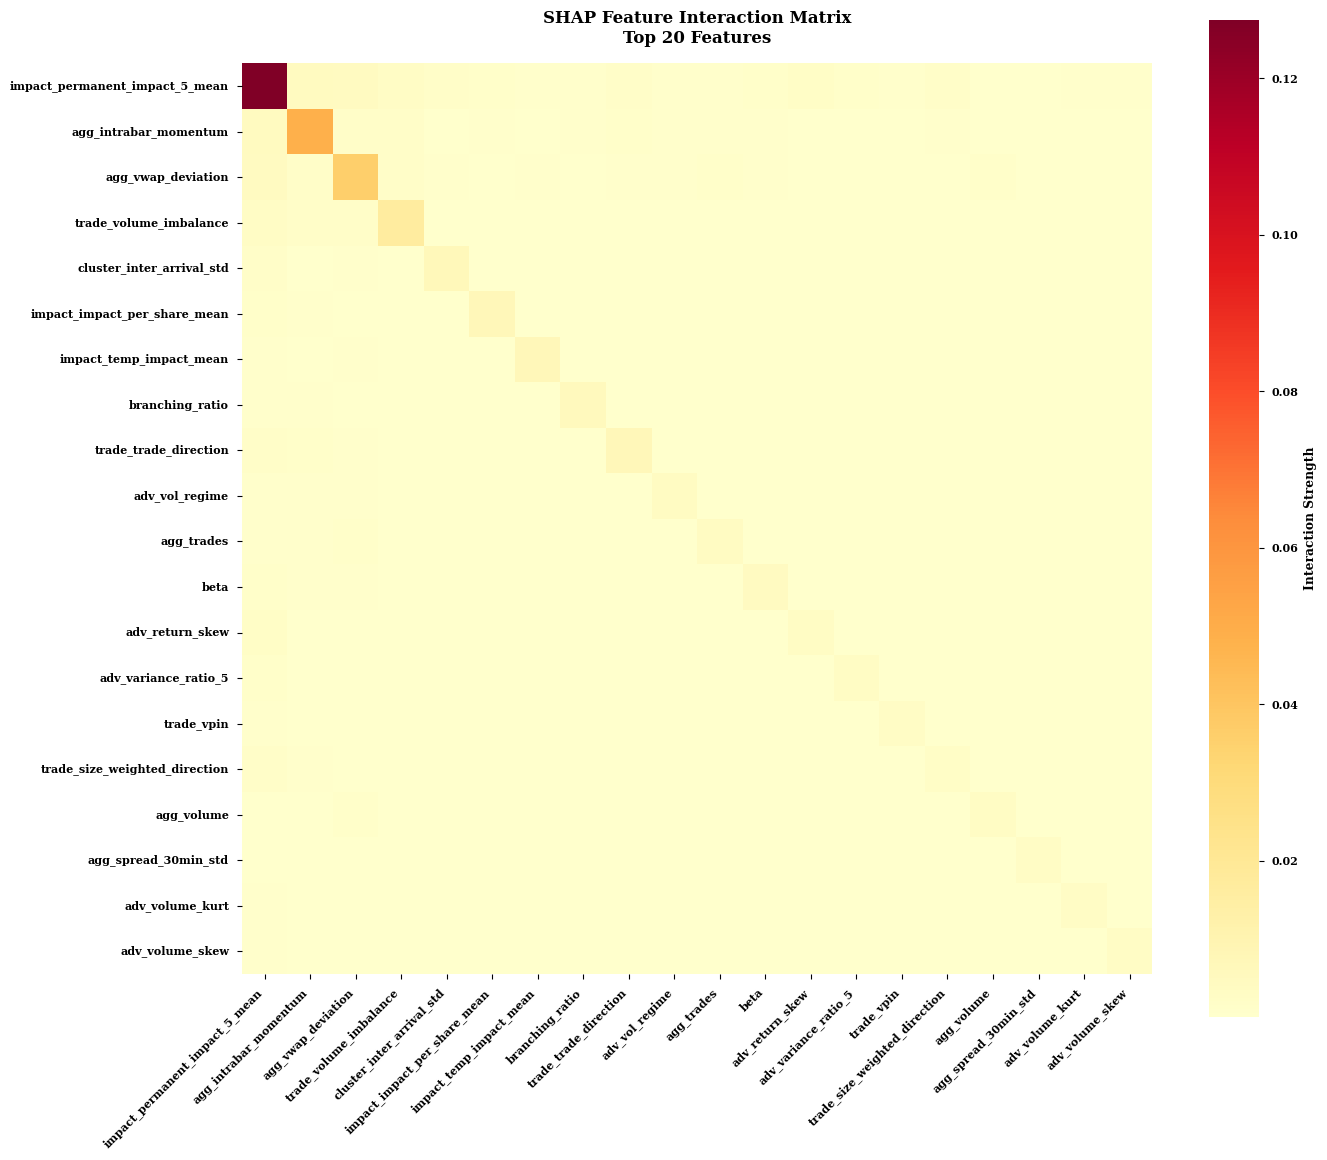


✓ Saved to /Users/rylanspence/Desktop/Git/HF/HFT-Equity-Prediction-Pipeline/notebooks/../reports/figures/feature_importance/shap_interaction_heatmap.png


In [22]:
# Visualize top interactions as heatmap (top 20 features)
top_20_features = shap_importance.head(20)["feature"].values
top_20_indices = [feature_cols.index(f) for f in top_20_features]

interaction_subset = interaction_matrix[np.ix_(top_20_indices, top_20_indices)]

plt.figure(figsize=(14, 12))
sns.heatmap(
    interaction_subset,
    xticklabels=top_20_features,
    yticklabels=top_20_features,
    cmap="YlOrRd",
    cbar_kws={"label": "Interaction Strength"},
    square=True,
)
plt.title(
    "SHAP Feature Interaction Matrix\nTop 20 Features",
    fontsize=12,
    fontweight="bold",
    pad=15,
)
plt.xticks(rotation=45, ha="right", fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.savefig(fi_dir / "shap_interaction_heatmap.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"\n✓ Saved to {fi_dir / 'shap_interaction_heatmap.png'}")

## 13. Save Results


In [23]:
# Save all importance tables
print("Saving feature importance tables...\n")

# Built-in importances
dt_importance.to_csv(TABLES_DIR / "dt_builtin_importance.csv", index=False)
rf_importance.to_csv(TABLES_DIR / "rf_builtin_importance.csv", index=False)
gb_importance.to_csv(TABLES_DIR / "gb_builtin_importance.csv", index=False)

# Permutation importances
dt_perm_importance.to_csv(TABLES_DIR / "dt_permutation_importance.csv", index=False)
rf_perm_importance.to_csv(TABLES_DIR / "rf_permutation_importance.csv", index=False)
gb_perm_importance.to_csv(TABLES_DIR / "gb_permutation_importance.csv", index=False)

# SHAP importance
shap_importance.to_csv(TABLES_DIR / "rf_shap_importance.csv", index=False)

# Cross-method comparison
comparison.to_csv(TABLES_DIR / "rf_importance_cross_method.csv", index=False)

# Top interactions
top_interactions_df.to_csv(TABLES_DIR / "shap_top_interactions.csv", index=False)

# Regime-conditional importances
if has_regime_models and len(regime_models_rf) > 0:
    for regime, importance_df in regime_importances.items():
        safe_regime_name = regime.replace(" ", "_").replace("/", "_")
        importance_df.to_csv(
            TABLES_DIR / f"regime_{safe_regime_name}_importance.csv", index=False
        )

print("✓ Tables saved:")
print(f"  Built-in importances: {TABLES_DIR / 'dt_builtin_importance.csv'}")
print(f"  Permutation importances: {TABLES_DIR / 'rf_permutation_importance.csv'}")
print(f"  SHAP importances: {TABLES_DIR / 'rf_shap_importance.csv'}")
print(f"  Cross-method comparison: {TABLES_DIR / 'rf_importance_cross_method.csv'}")
print(f"  Top interactions: {TABLES_DIR / 'shap_top_interactions.csv'}")

Saving feature importance tables...

✓ Tables saved:
  Built-in importances: /Users/rylanspence/Desktop/Git/HF/HFT-Equity-Prediction-Pipeline/notebooks/../reports/tables/dt_builtin_importance.csv
  Permutation importances: /Users/rylanspence/Desktop/Git/HF/HFT-Equity-Prediction-Pipeline/notebooks/../reports/tables/rf_permutation_importance.csv
  SHAP importances: /Users/rylanspence/Desktop/Git/HF/HFT-Equity-Prediction-Pipeline/notebooks/../reports/tables/rf_shap_importance.csv
  Cross-method comparison: /Users/rylanspence/Desktop/Git/HF/HFT-Equity-Prediction-Pipeline/notebooks/../reports/tables/rf_importance_cross_method.csv
  Top interactions: /Users/rylanspence/Desktop/Git/HF/HFT-Equity-Prediction-Pipeline/notebooks/../reports/tables/shap_top_interactions.csv


In [24]:
# Save summary results as JSON
results = {
    "ticker": TICKER,
    "start_date": START_DATE,
    "end_date": END_DATE,
    "date_range": DATE_RANGE,
    "n_features": len(feature_cols),
    "n_test_samples": len(X_test),
    "n_shap_samples": n_shap_samples,
    "top_10_builtin_rf": rf_importance.head(10)[["feature", "importance"]].to_dict(
        "records"
    ),
    "top_10_permutation_rf": rf_perm_importance.head(10)[
        ["feature", "importance_mean", "importance_std"]
    ].to_dict("records"),
    "top_10_shap_rf": shap_importance.head(10)[["feature", "importance"]].to_dict(
        "records"
    ),
    "top_10_interactions": top_interactions_df.head(10).to_dict("records"),
    "builtin_concentration": {
        "top_10_pct": float(
            100
            * rf_importance.head(10)["importance"].sum()
            / rf_importance["importance"].sum()
        ),
        "top_20_pct": float(
            100
            * rf_importance.head(20)["importance"].sum()
            / rf_importance["importance"].sum()
        ),
    },
    "shap_concentration": {
        "top_10_pct": float(
            100
            * shap_importance.head(10)["importance"].sum()
            / shap_importance["importance"].sum()
        ),
        "top_20_pct": float(
            100
            * shap_importance.head(20)["importance"].sum()
            / shap_importance["importance"].sum()
        ),
    },
}

with open(MODELS_DIR / "feature_importance_results.json", "w") as f:
    json.dump(results, f, indent=2)

print(f"\n✓ Results saved to {MODELS_DIR / 'feature_importance_results.json'}")


✓ Results saved to /Users/rylanspence/Desktop/Git/HF/HFT-Equity-Prediction-Pipeline/notebooks/../models/feature_importance_results.json


## 14. Summary


In [25]:
print("=" * 80)
print(f"FEATURE IMPORTANCE ANALYSIS SUMMARY - {TICKER} ({START_DATE} to {END_DATE})")
print("=" * 80)

print(f"\nDATA COVERAGE:")
print(f"  Ticker: {TICKER}")
print(f"  Period: {START_DATE} to {END_DATE} (5 trading days)")
print(f"  Features analyzed: {len(feature_cols)}")
print(f"  Test samples: {len(X_test):,}")
print(f"  SHAP samples: {n_shap_samples:,}")

print(f"\nMETHODS APPLIED:")
print(f"  1. Built-in importances (Gini/Gain)")
print(f"  2. Permutation importance (F1 score)")
print(f"  3. SHAP values (game-theoretic attribution)")
print(f"  4. SHAP interactions (feature synergies)")

print(f"\nTOP 5 FEATURES BY METHOD (Random Forest):")

print(f"\n  Built-in (Gini):")
for i, row in rf_importance.head(5).iterrows():
    print(f"    {i+1}. {row['feature']:40s} ({row['importance']:.4f})")

print(f"\n  Permutation:")
for i, row in rf_perm_importance.head(5).iterrows():
    print(
        f"    {i+1}. {row['feature']:40s} ({row['importance_mean']:.4f} ± {row['importance_std']:.4f})"
    )

print(f"\n  SHAP:")
for i, row in shap_importance.head(5).iterrows():
    print(f"    {i+1}. {row['feature']:40s} ({row['importance']:.4f})")

print(f"\nFEATURE CONCENTRATION:")
print(
    f"  Top 10 features (Built-in): {results['builtin_concentration']['top_10_pct']:.1f}% of total importance"
)
print(
    f"  Top 10 features (SHAP):     {results['shap_concentration']['top_10_pct']:.1f}% of total importance"
)

print(f"\nTOP 3 FEATURE INTERACTIONS:")
for i, row in top_interactions_df.head(3).iterrows():
    print(
        f"  {i+1}. {row['feature_1']} × {row['feature_2']}: {row['interaction_strength']:.4f}"
    )

if has_regime_models and len(regime_models_rf) > 0:
    print(f"\nREGIME-CONDITIONAL INSIGHTS:")
    for regime, importance_df in regime_importances.items():
        top_feature = importance_df.iloc[0]
        print(
            f"  {regime:12s}: Top feature = {top_feature['feature']} ({top_feature['importance']:.4f})"
        )

print(f"\nKEY FINDINGS (5-day analysis):")
print(
    f"  - {len([f for f in rf_importance['importance'] if f > 0])} out of {len(feature_cols)} features have non-zero importance"
)
print(
    f"  - Top 10 features account for {results['shap_concentration']['top_10_pct']:.1f}% of predictive power (SHAP)"
)
print(
    f"  - SHAP analysis reveals directionality: which features push predictions up vs. down"
)
print(
    f"  - Feature interactions detected: {top_interactions_df['interaction_strength'].gt(0.01).sum()} significant pairs"
)
if has_regime_models and len(regime_models_rf) > 0:
    print(
        f"  - Regime-conditional analysis shows different features dominate in different market states"
    )

print(f"\nVISUALIZATIONS CREATED:")
print(f"  - Built-in importance comparison (3 models)")
print(f"  - Permutation importance with confidence intervals")
print(f"  - SHAP summary plot (beeswarm)")
print(f"  - SHAP dependence plots (top 6 features)")
print(f"  - SHAP waterfall plots (individual predictions)")
print(f"  - Cross-method comparison")
print(f"  - SHAP interaction heatmap")
if has_regime_models and len(regime_models_rf) > 0:
    print(f"  - Regime-conditional importance comparison")

print(f"\nNEXT STEPS:")
print(f"  - Notebook 65: Model interpretability (decision paths, partial dependence)")
print(f"  - Notebook 70: Regime validation (economic trading simulation)")
print(f"  - Notebook 75: Production benchmarks (latency, optimization)")

print("\n" + "=" * 80)

FEATURE IMPORTANCE ANALYSIS SUMMARY - AAPL (2024-12-09 to 2024-12-13)

DATA COVERAGE:
  Ticker: AAPL
  Period: 2024-12-09 to 2024-12-13 (5 trading days)
  Features analyzed: 81
  Test samples: 273
  SHAP samples: 273

METHODS APPLIED:
  1. Built-in importances (Gini/Gain)
  2. Permutation importance (F1 score)
  3. SHAP values (game-theoretic attribution)
  4. SHAP interactions (feature synergies)

TOP 5 FEATURES BY METHOD (Random Forest):

  Built-in (Gini):
    65. impact_permanent_impact_5_mean           (0.2992)
    12. agg_vwap_deviation                       (0.0885)
    14. agg_intrabar_momentum                    (0.0719)
    41. trade_volume_imbalance                   (0.0239)
    66. impact_impact_per_share_mean             (0.0171)

  Permutation:
    65. impact_permanent_impact_5_mean           (0.0881 ± 0.0295)
    12. agg_vwap_deviation                       (0.0198 ± 0.0094)
    14. agg_intrabar_momentum                    (0.0177 ± 0.0079)
    63. impact_temp_impact_me